# Прогнозирование временных рядов с использованием Informer

Автоматический поиск архитектур (NAS) для задачи time-series forecasting с метрикой MSE.

## 1. Импорт библиотек

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm
import optuna
import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Устройство: {device}")

Устройство: cuda


## 2. Загрузка и подготовка данных

In [2]:
url_eth1 = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
url_eth2 = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv"

df_eth1 = pd.read_csv(url_eth1)
df_eth2 = pd.read_csv(url_eth2)

print(f"ETTh1: {df_eth1.shape}")
print(f"ETTh2: {df_eth2.shape}")
print(f"Столбцы: {df_eth1.columns.tolist()}")

ETTh1: (17420, 8)
ETTh2: (17420, 8)
Столбцы: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


In [3]:
train_size = 12 * 30 * 24
val_size = 4 * 30 * 24

train_df = df_eth1[:train_size]
val_df = df_eth1[train_size:train_size + val_size]
test_df = df_eth1[train_size + val_size:train_size + 2*val_size]

feature_cols = [col for col in df_eth1.columns if col != 'date']
target_col = 'OT'

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")
print(f"Признаки: {feature_cols}")

Train: (8640, 8), Val: (2880, 8), Test: (2880, 8)
Признаки: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


## 3. Класс Dataset

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, label_len, pred_len, features, target='OT', flag='train', scale=True, scaler=None):
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len
        self.features = features
        self.target = target
        self.flag = flag
        
        self.data_x = data[features].values
        self.data_y = data[target].values
        
        if scale:
            if scaler is None:
                self.scaler = StandardScaler()
                self.data_x = self.scaler.fit_transform(self.data_x)
            else:
                self.scaler = scaler
                self.data_x = self.scaler.transform(self.data_x)
        else:
            self.scaler = None
    
    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_x[r_begin:r_end]
        seq_x_mark = np.zeros((self.seq_len, 4))
        seq_y_mark = np.zeros((self.label_len + self.pred_len, 4))
        
        return seq_x, seq_y, seq_x_mark, seq_y_mark



## 4. Клонирование репозитория Informer2020

In [5]:
if not os.path.exists('Informer2020'):
    !git clone https://github.com/zhouhaoyi/Informer2020.git
    print("Репозиторий клонирован")
else:
    print("Репозиторий уже существует")

sys.path.append('Informer2020')
from models.model import Informer

Репозиторий уже существует


## 5. Функция создания модели

In [6]:
def create_model(config):
    model = Informer(
        enc_in=config['enc_in'],
        dec_in=config['dec_in'],
        c_out=config['c_out'],
        seq_len=config['seq_len'],
        label_len=config['label_len'],
        out_len=config['pred_len'],
        factor=config.get('factor', 5),
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        e_layers=config['e_layers'],
        d_layers=config['d_layers'],
        d_ff=config['d_ff'],
        dropout=config['dropout'],
        attn='prob',
        embed='timeF',
        freq='h',
        activation='gelu',
        output_attention=False,
        distil=True,
        mix=True
    ).to(device)
    return model


## 6. Цикл обучения

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, label_len, pred_len):
    model.train()
    total_loss = 0
    
    for batch_x, batch_y, batch_x_mark, batch_y_mark in tqdm(dataloader, desc='Train epoch', leave=False):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)
        
        dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        
        f_dim = -1
        outputs = outputs[:, -pred_len:, f_dim:]
        batch_y = batch_y[:, -pred_len:, f_dim:].to(device)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, label_len, pred_len):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in tqdm(dataloader, desc='Val epoch', leave=False):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)
            
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
            
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            
            f_dim = -1
            outputs = outputs[:, -pred_len:, f_dim:]
            batch_y = batch_y[:, -pred_len:, f_dim:].to(device)
            
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)


## 7. Optuna: Подбор гиперпараметров

In [8]:
def objective(trial: optuna.Trial):
    d_model = trial.suggest_categorical('d_model', [128, 256, 512])
    n_heads = trial.suggest_categorical('n_heads', [4, 8, 16])
    
    # Проверяем, что d_model делится на n_heads
    if d_model % n_heads != 0:
        # Если комбинация невалидна, возвращаем большое значение
        raise optuna.TrialPruned()
    
    config = {
        'enc_in': len(feature_cols),
        'dec_in': len(feature_cols),
        'c_out': len(feature_cols),
        'seq_len': trial.suggest_categorical('seq_len', [168, 336, 720]),
        'label_len': trial.suggest_categorical('label_len', [24, 48, 72]),
        'pred_len': 96,  
        'd_model': d_model,
        'n_heads': n_heads,
        'e_layers': trial.suggest_int('e_layers', 2, 4),
        'd_layers': trial.suggest_int('d_layers', 1, 2),
        'd_ff': trial.suggest_categorical('d_ff', [256, 512, 1024, 2048]),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'factor': trial.suggest_int('factor', 3, 5),
    }
    
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    
    train_dataset = TimeSeriesDataset(
        train_df, config['seq_len'], config['label_len'], config['pred_len'], 
        feature_cols, target_col, 'train', scale=True
    )
    val_dataset = TimeSeriesDataset(
        val_df, config['seq_len'], config['label_len'], config['pred_len'],
        feature_cols, target_col, 'val', scale=True, scaler=train_dataset.scaler
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = create_model(config)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    
    best_val_loss = float('inf')
    patience = 5  
    patience_counter = 0
    
    for epoch in tqdm(range(20), desc='Epochs'):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, config['label_len'], config['pred_len'])
        val_loss = validate(model, val_loader, criterion, config['label_len'], config['pred_len'])
        scheduler.step()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
        
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_loss


In [14]:
sampler = optuna.samplers.TPESampler(
    seed=777, 
    n_startup_trials=10, 
    multivariate=True,  
)

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,  
    n_warmup_steps=5,  
    interval_steps=1,  
)

study = optuna.create_study(
    direction='minimize',
    study_name='informer_nas_improved',
    sampler=sampler,
    pruner=pruner,
)

study.optimize(objective, n_trials=50, show_progress_bar=True)


[I 2025-11-21 20:44:46,098] A new study created in memory with name: informer_nas_improved


  0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 20:45:41,114] Trial 0 finished with value: 0.1574187871450797 and parameters: {'d_model': 256, 'n_heads': 16, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.1344300289441296, 'factor': 4, 'batch_size': 64, 'learning_rate': 2.434023748476432e-05}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

[I 2025-11-21 20:47:03,835] Trial 1 finished with value: 0.1759290763678459 and parameters: {'d_model': 256, 'n_heads': 16, 'seq_len': 720, 'label_len': 24, 'e_layers': 3, 'd_layers': 2, 'd_ff': 256, 'dropout': 0.3630690610596704, 'factor': 4, 'batch_size': 16, 'learning_rate': 0.00012634449218691999}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

[I 2025-11-21 20:48:01,207] Trial 2 finished with value: 0.2799577877243481 and parameters: {'d_model': 256, 'n_heads': 4, 'seq_len': 168, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.41797170477028295, 'factor': 4, 'batch_size': 16, 'learning_rate': 0.00028477336317640496}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 20:48:58,462] Trial 3 finished with value: 0.31724562338710605 and parameters: {'d_model': 256, 'n_heads': 4, 'seq_len': 336, 'label_len': 72, 'e_layers': 3, 'd_layers': 1, 'd_ff': 512, 'dropout': 0.1632944069148008, 'factor': 5, 'batch_size': 16, 'learning_rate': 0.0008521228483939395}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

[I 2025-11-21 20:50:08,450] Trial 4 finished with value: 0.18155099440253142 and parameters: {'d_model': 128, 'n_heads': 8, 'seq_len': 720, 'label_len': 72, 'e_layers': 2, 'd_layers': 2, 'd_ff': 512, 'dropout': 0.3640500670523297, 'factor': 4, 'batch_size': 64, 'learning_rate': 1.6293898438553143e-05}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

[I 2025-11-21 20:51:16,659] Trial 5 finished with value: 0.21380436555596022 and parameters: {'d_model': 128, 'n_heads': 4, 'seq_len': 168, 'label_len': 24, 'e_layers': 4, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.31802530207551083, 'factor': 5, 'batch_size': 16, 'learning_rate': 0.0004688976497386717}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

[I 2025-11-21 20:52:05,146] Trial 6 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/262 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/82 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/262 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/82 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/262 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/82 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/262 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/82 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/262 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/82 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/262 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/82 [00:00<?, ?it/s]

[I 2025-11-21 20:52:33,613] Trial 7 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

[I 2025-11-21 20:53:52,751] Trial 8 finished with value: 0.3760896041416205 and parameters: {'d_model': 128, 'n_heads': 4, 'seq_len': 720, 'label_len': 24, 'e_layers': 4, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.07745821405353337, 'factor': 3, 'batch_size': 16, 'learning_rate': 0.00010759706842657497}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 20:54:34,777] Trial 9 finished with value: 0.27841371316940355 and parameters: {'d_model': 512, 'n_heads': 4, 'seq_len': 336, 'label_len': 48, 'e_layers': 2, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.447578038255722, 'factor': 4, 'batch_size': 64, 'learning_rate': 0.00018576430983325355}. Best is trial 0 with value: 0.1574187871450797.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 20:55:42,179] Trial 10 finished with value: 0.1522499767060463 and parameters: {'d_model': 512, 'n_heads': 16, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.036313105308704574, 'factor': 4, 'batch_size': 64, 'learning_rate': 1.051800542097701e-05}. Best is trial 10 with value: 0.1522499767060463.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 20:56:36,053] Trial 11 finished with value: 0.14777060688879246 and parameters: {'d_model': 256, 'n_heads': 16, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.14445593073521085, 'factor': 4, 'batch_size': 64, 'learning_rate': 2.505638937104014e-05}. Best is trial 11 with value: 0.14777060688879246.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 20:57:35,249] Trial 12 finished with value: 0.17477863673598337 and parameters: {'d_model': 512, 'n_heads': 16, 'seq_len': 336, 'label_len': 24, 'e_layers': 4, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.03971436314561374, 'factor': 3, 'batch_size': 64, 'learning_rate': 1.716268353747666e-05}. Best is trial 11 with value: 0.14777060688879246.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 20:58:00,656] Trial 13 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 20:59:33,480] Trial 14 finished with value: 0.16506555406739573 and parameters: {'d_model': 512, 'n_heads': 16, 'seq_len': 336, 'label_len': 48, 'e_layers': 3, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.11484671534053505, 'factor': 4, 'batch_size': 16, 'learning_rate': 1.1190701356406614e-05}. Best is trial 11 with value: 0.14777060688879246.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

[I 2025-11-21 21:00:34,256] Trial 15 finished with value: 0.1865016059925804 and parameters: {'d_model': 512, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.07199771089707116, 'factor': 5, 'batch_size': 32, 'learning_rate': 3.824224901837605e-05}. Best is trial 11 with value: 0.14777060688879246.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:02:10,418] Trial 16 finished with value: 0.1119415215574778 and parameters: {'d_model': 512, 'n_heads': 16, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.3370289588925187, 'factor': 4, 'batch_size': 64, 'learning_rate': 1.6033462452150833e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:04:28,106] Trial 17 finished with value: 0.15505139357768571 and parameters: {'d_model': 512, 'n_heads': 16, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.3887566467494293, 'factor': 4, 'batch_size': 64, 'learning_rate': 1.2222341684768045e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

[I 2025-11-21 21:05:03,767] Trial 18 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:06:33,733] Trial 19 finished with value: 0.1334539581719157 and parameters: {'d_model': 512, 'n_heads': 4, 'seq_len': 336, 'label_len': 24, 'e_layers': 4, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.34447612089950824, 'factor': 3, 'batch_size': 16, 'learning_rate': 1.6220255424175274e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:08:22,375] Trial 20 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/490 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/130 [00:00<?, ?it/s]

[I 2025-11-21 21:10:21,460] Trial 21 finished with value: 0.2530421141248483 and parameters: {'d_model': 512, 'n_heads': 4, 'seq_len': 720, 'label_len': 48, 'e_layers': 4, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.3384790122524191, 'factor': 3, 'batch_size': 16, 'learning_rate': 1.269343248723901e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/524 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/164 [00:00<?, ?it/s]

[I 2025-11-21 21:11:51,373] Trial 22 finished with value: 0.29879776522426343 and parameters: {'d_model': 512, 'n_heads': 4, 'seq_len': 168, 'label_len': 24, 'e_layers': 4, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.3100422032425268, 'factor': 3, 'batch_size': 16, 'learning_rate': 1.1192923262799943e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:13:17,985] Trial 23 finished with value: 0.19808705834454143 and parameters: {'d_model': 512, 'n_heads': 16, 'seq_len': 336, 'label_len': 72, 'e_layers': 4, 'd_layers': 1, 'd_ff': 512, 'dropout': 0.3883907590232698, 'factor': 3, 'batch_size': 16, 'learning_rate': 2.7459192350163503e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

[I 2025-11-21 21:14:18,075] Trial 24 finished with value: 0.16270789003314137 and parameters: {'d_model': 512, 'n_heads': 4, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 512, 'dropout': 0.3496292893750403, 'factor': 3, 'batch_size': 32, 'learning_rate': 1.2592182649521932e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

[I 2025-11-21 21:14:53,618] Trial 25 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

[I 2025-11-21 21:15:42,962] Trial 26 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:16:46,651] Trial 27 finished with value: 0.14446459846063095 and parameters: {'d_model': 256, 'n_heads': 4, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.3423587445852873, 'factor': 3, 'batch_size': 16, 'learning_rate': 3.1142974359351016e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:18:02,450] Trial 28 finished with value: 0.16328173675030083 and parameters: {'d_model': 128, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 4, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.34798825960037383, 'factor': 3, 'batch_size': 16, 'learning_rate': 2.1623820405808297e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:19:06,313] Trial 29 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/245 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/65 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/245 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/65 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/245 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/65 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/245 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/65 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/245 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/65 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/245 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/65 [00:00<?, ?it/s]

[I 2025-11-21 21:20:00,646] Trial 30 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

[I 2025-11-21 21:20:31,722] Trial 31 finished with value: 0.23018008861236455 and parameters: {'d_model': 512, 'n_heads': 16, 'seq_len': 168, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.12810607440344457, 'factor': 4, 'batch_size': 64, 'learning_rate': 5.422991001387578e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

[I 2025-11-21 21:21:23,063] Trial 32 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:22:44,860] Trial 33 finished with value: 0.1318519856685247 and parameters: {'d_model': 256, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.08917552178463628, 'factor': 4, 'batch_size': 64, 'learning_rate': 1.1764698996356716e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

[I 2025-11-21 21:23:10,131] Trial 34 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:24:31,935] Trial 35 finished with value: 0.15875278545132318 and parameters: {'d_model': 256, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.01916762525652803, 'factor': 4, 'batch_size': 16, 'learning_rate': 1.0079091876424533e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:26:02,511] Trial 36 finished with value: 0.2137888220150943 and parameters: {'d_model': 512, 'n_heads': 4, 'seq_len': 336, 'label_len': 24, 'e_layers': 4, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.2835956263353865, 'factor': 3, 'batch_size': 16, 'learning_rate': 1.8772051456698876e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/131 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/41 [00:00<?, ?it/s]

[I 2025-11-21 21:26:20,589] Trial 37 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:27:36,877] Trial 38 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:28:10,394] Trial 39 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:29:12,783] Trial 40 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/257 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/77 [00:00<?, ?it/s]

[I 2025-11-21 21:29:58,046] Trial 41 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:30:40,970] Trial 42 finished with value: 0.14760786075240526 and parameters: {'d_model': 256, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.1191719660956379, 'factor': 5, 'batch_size': 64, 'learning_rate': 2.219543316888261e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:31:16,091] Trial 43 pruned. 


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/514 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/154 [00:00<?, ?it/s]

[I 2025-11-21 21:32:17,552] Trial 44 finished with value: 0.17812729365639873 and parameters: {'d_model': 256, 'n_heads': 4, 'seq_len': 336, 'label_len': 72, 'e_layers': 3, 'd_layers': 1, 'd_ff': 512, 'dropout': 0.23741744828425757, 'factor': 3, 'batch_size': 16, 'learning_rate': 3.213934864234647e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:33:05,211] Trial 45 finished with value: 0.21223189409535664 and parameters: {'d_model': 512, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.044936376176432924, 'factor': 4, 'batch_size': 64, 'learning_rate': 3.028574194210021e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:33:38,900] Trial 46 finished with value: 0.16207889066292688 and parameters: {'d_model': 256, 'n_heads': 4, 'seq_len': 336, 'label_len': 72, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.02800198860857682, 'factor': 5, 'batch_size': 64, 'learning_rate': 2.9294894636850066e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:34:24,590] Trial 47 finished with value: 0.13413987800669977 and parameters: {'d_model': 256, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 2, 'd_ff': 256, 'dropout': 0.12038502053547963, 'factor': 5, 'batch_size': 64, 'learning_rate': 2.0100446064219467e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/123 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/33 [00:00<?, ?it/s]

[I 2025-11-21 21:35:22,326] Trial 48 finished with value: 0.25593971833586693 and parameters: {'d_model': 256, 'n_heads': 8, 'seq_len': 720, 'label_len': 72, 'e_layers': 3, 'd_layers': 2, 'd_ff': 256, 'dropout': 0.03760104598953408, 'factor': 5, 'batch_size': 64, 'learning_rate': 1.7737510833924297e-05}. Best is trial 16 with value: 0.1119415215574778.


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2025-11-21 21:36:22,349] Trial 49 finished with value: 0.12688549092182747 and parameters: {'d_model': 256, 'n_heads': 8, 'seq_len': 336, 'label_len': 24, 'e_layers': 2, 'd_layers': 2, 'd_ff': 512, 'dropout': 0.09276393028490909, 'factor': 5, 'batch_size': 64, 'learning_rate': 1.4243365834178947e-05}. Best is trial 16 with value: 0.1119415215574778.


In [17]:
import json
with open('best_params.json', 'w') as f:
    json.dump(study.best_params, f, indent=4)

In [20]:
import pickle
with open('study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [23]:
study.best_trial

FrozenTrial(number=16, state=<TrialState.COMPLETE: 1>, values=[0.1119415215574778], datetime_start=datetime.datetime(2025, 11, 21, 21, 0, 34, 258844), datetime_complete=datetime.datetime(2025, 11, 21, 21, 2, 10, 418299), params={'d_model': 512, 'n_heads': 16, 'seq_len': 336, 'label_len': 24, 'e_layers': 3, 'd_layers': 1, 'd_ff': 1024, 'dropout': 0.3370289588925187, 'factor': 4, 'batch_size': 64, 'learning_rate': 1.6033462452150833e-05}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.1978469729805604, 1: 0.12994951410935476, 2: 0.1233252555800554, 3: 0.12217297405004501, 4: 0.1119415215574778, 5: 0.11977463354093906, 6: 0.12363273698167923, 7: 0.12905307582173592, 8: 0.1340293046564628}, distributions={'d_model': CategoricalDistribution(choices=(128, 256, 512)), 'n_heads': CategoricalDistribution(choices=(4, 8, 16)), 'seq_len': CategoricalDistribution(choices=(168, 336, 720)), 'label_len': CategoricalDistribution(choices=(24, 48, 72)), 'e_layers': IntDistribution(high=4, log=

In [9]:
import pickle
with open('study.pkl', 'rb') as f:
    study = pickle.load(f)

In [11]:
best_params = study.best_params
best_params

{'d_model': 512,
 'n_heads': 16,
 'seq_len': 336,
 'label_len': 24,
 'e_layers': 3,
 'd_layers': 1,
 'd_ff': 1024,
 'dropout': 0.3370289588925187,
 'factor': 4,
 'batch_size': 64,
 'learning_rate': 1.6033462452150833e-05}

## 8. Обучение финальной модели

In [26]:
best_config = {
    'enc_in': len(feature_cols),
    'dec_in': len(feature_cols),
    'c_out': len(feature_cols),
    'seq_len': study.best_params['seq_len'],
    'label_len': study.best_params['label_len'],
    'pred_len': 96,
    'd_model': study.best_params['d_model'],
    'n_heads': study.best_params['n_heads'],
    'e_layers': study.best_params['e_layers'],
    'd_layers': study.best_params['d_layers'],
    'd_ff': study.best_params['d_ff'],
    'dropout': study.best_params['dropout'],
    'factor': study.best_params.get('factor', 5),  # factor из оптимизации
}

best_batch_size = study.best_params.get('batch_size', 32)
best_lr = study.best_params.get('learning_rate', 1e-4)

train_dataset = TimeSeriesDataset(
    train_df, best_config['seq_len'], best_config['label_len'], best_config['pred_len'],
    feature_cols, target_col, 'train', scale=True
)
val_dataset = TimeSeriesDataset(
    val_df, best_config['seq_len'], best_config['label_len'], best_config['pred_len'],
    feature_cols, target_col, 'val', scale=True, scaler=train_dataset.scaler
)
test_dataset = TimeSeriesDataset(
    test_df, best_config['seq_len'], best_config['label_len'], best_config['pred_len'],
    feature_cols, target_col, 'test', scale=True, scaler=train_dataset.scaler
)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)

model = create_model(best_config)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print(f"Параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"Batch size: {best_batch_size}")
print(f"Learning rate: {best_lr:.2e}")

Параметров: 11,072,007
Batch size: 64
Learning rate: 1.60e-05


In [27]:
epochs = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

loop = tqdm(range(epochs), desc='Epochs')
for epoch in loop:
    train_loss = train_epoch(model, train_loader, criterion, optimizer, best_config['label_len'], best_config['pred_len'])
    val_loss = validate(model, val_loader, criterion, best_config['label_len'], best_config['pred_len'])
    scheduler.step()  
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    loop.set_postfix_str(f"Loss = {val_loss:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {current_lr:.2e}")
    
    if patience_counter >= patience:
        print(f"Early stopping на эпохе {epoch+1}. Лучший Val Loss: {best_val_loss:.6f}")
        break

print(f"\nОбучение завершено. Лучший Val Loss: {best_val_loss:.6f}")


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.161531, Val Loss: 0.119852, LR: 8.02e-06


Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/129 [00:00<?, ?it/s]

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.139725, Val Loss: 0.159155, LR: 0.00e+00
Early stopping на эпохе 10. Лучший Val Loss: 0.119852

Обучение завершено. Лучший Val Loss: 0.119852


## 9. Оценка на тестовых данных

In [28]:
model.load_state_dict(torch.load('best_model.pth'))
test_loss = validate(model, test_loader, criterion, best_config['label_len'], best_config['pred_len'])

print(f"Test MSE: {test_loss:.6f}")
print(f"Test RMSE: {np.sqrt(test_loss):.6f}")

Val epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Test MSE: 0.211994
Test RMSE: 0.460429


## 10. Визуализация

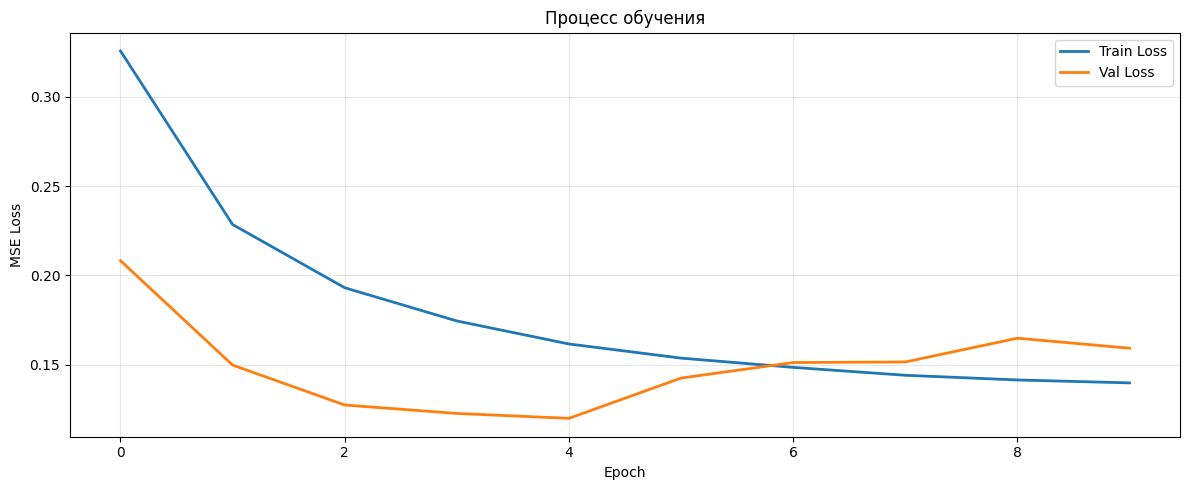

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Процесс обучения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

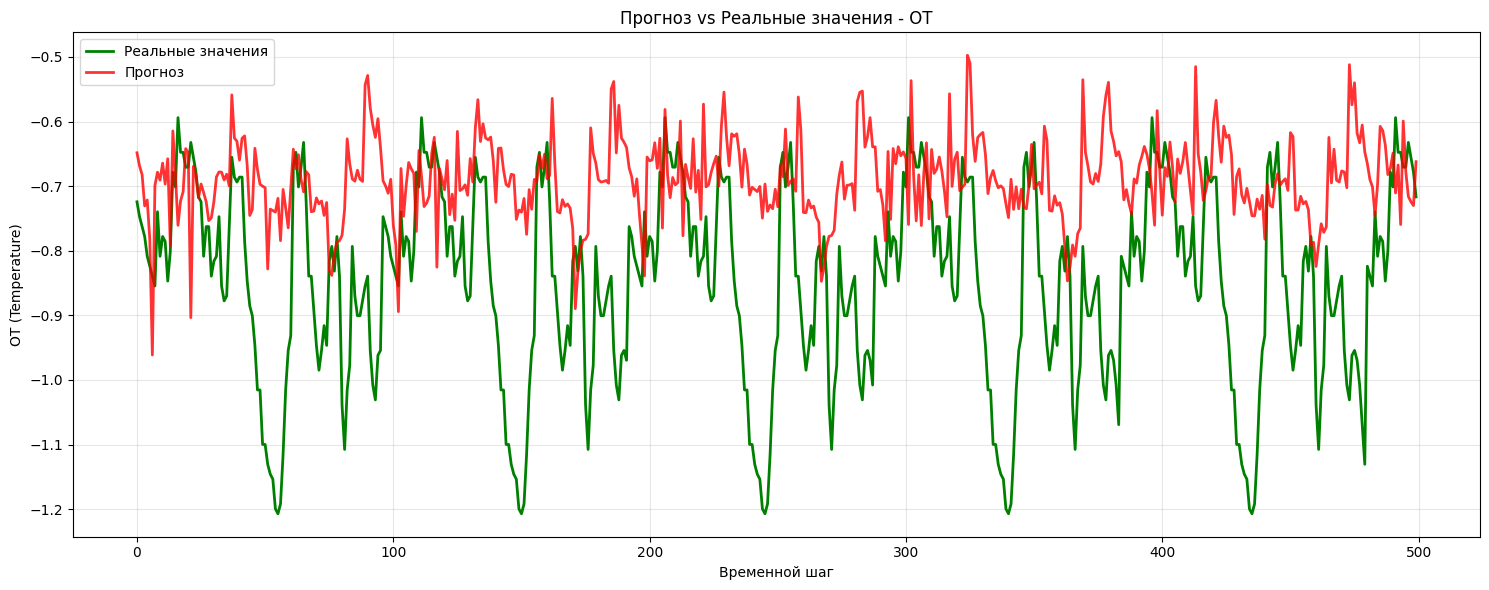


Метрики на тестовой выборке:
MSE: 0.049862
RMSE: 0.223299
MAE: 0.178053


In [36]:
model.eval()
predictions = []
actuals = []

label_len = best_config['label_len']
pred_len = best_config['pred_len']

with torch.no_grad():
    for batch_x, batch_y, batch_x_mark, batch_y_mark in test_loader:
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)
        
        dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
        
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        
        f_dim = -1
        outputs = outputs[:, -pred_len:, f_dim:]
        batch_y = batch_y[:, -pred_len:, f_dim:]
        
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Модель предсказывает один признак (последний dimension = 1), поэтому берем его напрямую
pred_target = predictions[:, :, 0].flatten()[:500]
actual_target = actuals[:, :, 0].flatten()[:500]

plt.figure(figsize=(15, 6))
plt.plot(actual_target, label='Реальные значения', linewidth=2, color='green')
plt.plot(pred_target, label='Прогноз', linewidth=2, color='red', alpha=0.8)
plt.xlabel('Временной шаг')
plt.ylabel(f'{target_col} (Temperature)')
plt.title(f'Прогноз vs Реальные значения - {target_col}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

mse = mean_squared_error(actual_target, pred_target)
mae = mean_absolute_error(actual_target, pred_target)
print(f"\nМетрики на тестовой выборке:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {np.sqrt(mse):.6f}")
print(f"MAE: {mae:.6f}")


## 11. История Optuna

In [12]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

fig = optuna.visualization.plot_param_importances(study)
fig.show()